## ECE495 Intro to programming neurons with Nengo: Dynamics

In this demonstration we will:

1. Perform matrix multiplication with greater than 2-dimensional neurons (this technically still falls within transformation)
2. Implement recurrence in a Nengo network
3. Create a delay using neurons

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

#### Matrix Multiplication

This example demonstrates how to perform general matrix multiplication using Nengo. The matrix can change during the computation, which makes it distinct from doing static matrix multiplication with neural connection weights (as done in all neural networks).

Let's compute $A \cdot B$, which is equal to $(B \cdot A)^T$ where

$A = \begin{bmatrix}
		.5 & -.5 \\
		-.2 & .3  
	\end{bmatrix}$  and  $B = 	\begin{bmatrix}
									.58 & -1 \\
									.7 & .1  
								\end{bmatrix}$

Big differences here:
- We are using an _EnsembleArray_ (i.e. an array of ensembles of neurons) instead of an _Ensemble_ of neurons
- We specifically _probe the outputs of an Ensemble Array_ since we need to probe each ensemble's output (not the array itself). This results in 4 outputs since we have an array of 4 ensembles of neurons



In [13]:
Amat = np.array([[0.5, -0.5], [-0.2, 0.3]])
Bmat = np.array([[0.58, -1.0], [0.7, 0.1]])

model = nengo.Network(label="Matrix Multiplication", seed=123)
with model:
    # Make 2 EnsembleArrays to encode the input
    # Amat.size and Bmat.size = 4, therefore 4D neurons used
    # Values should stay within the range (-radius, radius)
    A = nengo.networks.EnsembleArray(n_neurons = 100, n_ensembles=Amat.size, radius=1) 
    B = nengo.networks.EnsembleArray(n_neurons = 100, n_ensembles=Bmat.size, radius=1)

    # Create 2 nodes to send in matrix values
    inputA = nengo.Node(Amat.ravel())  # ravel is equivalent to reshape(-1) i.e. flatten!
    inputB = nengo.Node(Bmat.ravel())

    # connect input nodes to neuron ensembles
    nengo.Connection(inputA, A.input)
    nengo.Connection(inputB, B.input)

    # Probe to check we've connected correctly
    #  Note: must probe the output of each ensemble because 
    #        we are using an array of ensembles!
    #
    # sample_every determines how many timesteps you plot
    #  in this case, it's fewer times than the simulation would plot
    # default simulation dt = .001
    A_probe = nengo.Probe(A.output, sample_every=0.01, synapse=0.01) 
    B_probe = nengo.Probe(B.output, sample_every=0.01, synapse=0.01)

#### Run and Plot

Build finished in 0:00:01.                                                      


Simulation finished in 0:00:01.                                                 


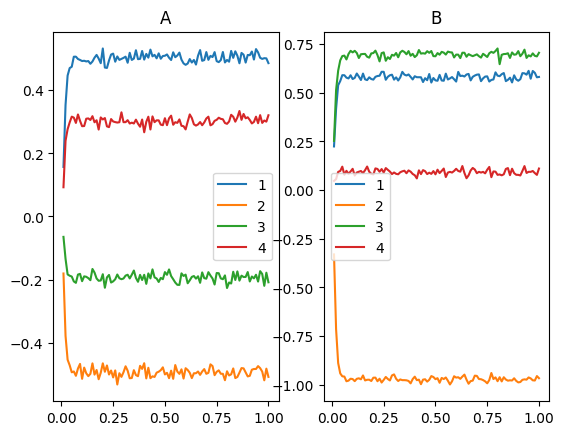

In [14]:
with nengo.Simulator(model) as sim:
    sim.run(1)
plt.figure()
plt.subplot(1, 2, 1)
plt.title("A")
plt.plot(sim.trange(sample_every=0.01), sim.data[A_probe])
plt.legend(['1','2','3','4'], loc="best")

plt.subplot(1, 2, 2)
plt.title("B")
plt.plot(sim.trange(sample_every=0.01), sim.data[B_probe])
plt.legend(['1','2','3','4'], loc="best")

Inputs look good, but now we need to actually perform each multiplication that occurs in matrix multiplication. 

First, we will use one of Nengo's reusable networks `product` instead of manually creating multiplication neurons as we did in `neuron_transformations.ipynb` (although we could definitely do it this way!). The `product` network computes the element-wise product of two equally sized vectors where `input_a` is the first vector and `input_b` is the second. Read more about different reusable networks [here](https://www.nengo.ai/nengo/networks.html#nengo.networks.Product).

You'll notice we call an argument `transform`. In decoded connections, weights are automatically determined through decoder solving (what we've done in neuron reps and transformations). In direct connections however, weights can be manually specified through the transform argument. Read more about this [here](https://www.nengo.ai/nengo/connections.html).

In [15]:
with model:
    # The C matrix is composed of populations that each contain
    # one element of A and one element of B.
    # These elements will be multiplied together in the next step.

    # For two 2x2 matrices to be multiplied together, there will be 
    #  8 total multiplications that will occur (think through this!)
    c_size = Amat.size * Bmat.shape[1] # 4*2 = 8
    C = nengo.networks.Product(100, dimensions=c_size)

# Determine the transformation matrices to get the correct pairwise
#   products computed. 
transformA = np.zeros((c_size, Amat.size))
transformB = np.zeros((c_size, Bmat.size))

for i in range(Amat.shape[0]):
    for j in range(Amat.shape[1]):
        for k in range(Bmat.shape[1]):
            c_index = j + k * Amat.shape[1] + i * Bmat.size
            transformA[c_index][j + i * Amat.shape[1]] = 1
            transformB[c_index][k + j * Bmat.shape[1]] = 1

print("A->C")
print(transformA)
print("B->C")
print(transformB)

with model:
    nengo.Connection(A.output, C.input_a, transform=transformA)
    nengo.Connection(B.output, C.input_b, transform=transformB)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)

A->C
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B->C
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


We printed the weights. Recall, we have two 2x2 matrices. Each matrix was flattened into an array of 4 values (indices 0 to 3). If there is a `1` in the tranform matrix, that means the element is "active" because it is weighted 1 instead of 0. So, for the first multiplication that must be performed, we have $a_0$ multiplied by $b_0$.

If you take a look at each transform matrix row by row, they line up to perform each multiplication required within two 2x2 matrices being multiplied. 

$$ \vec{A} \vec{B}  
=
\begin{bmatrix} 
	a_{11} & a_{12} \\
	a_{21} & a_{22}  
\end{bmatrix}
\begin{bmatrix} 
	b_{11} & b_{12} \\
	b_{21} & b_{22}  	
\end{bmatrix}
=
\begin{bmatrix} 
	a_{0} & a_{1} \\
	a_{2} & a_{3}  
\end{bmatrix}
\begin{bmatrix} 
	b_{0} & b_{1} \\
	b_{2} & b_{3}  	
\end{bmatrix}
\\ 
=
\begin{bmatrix} 
	a_{11}  b_{11} + a_{12}b_{21} & a_{11} b_{12}+a_{12}b_{22} \\
	a_{21}  b_{11} + a_{22}b_{21} & a_{21}  b_{12} + a_{22}b_{22} 	
\end{bmatrix} 
=
\begin{bmatrix} 
	a_{0}  b_{0} + a_{1}b_{2} & a_{0} b_{1}+a_{1}b_{3} \\
	a_{2}  b_{0} + a_{3}b_{2} & a_{2}  b_{1} + a_{0}b_{3} 	
\end{bmatrix} $$

Now, let's view the outputs of our 8-dimensional neuron ensemble C (created from a pre-built Nengo network `product`). This will output each of the individual multiplications. Note: no addition has occurred!

Build finished in 0:00:02.                                                      
Simulation finished in 0:00:03.                                                 


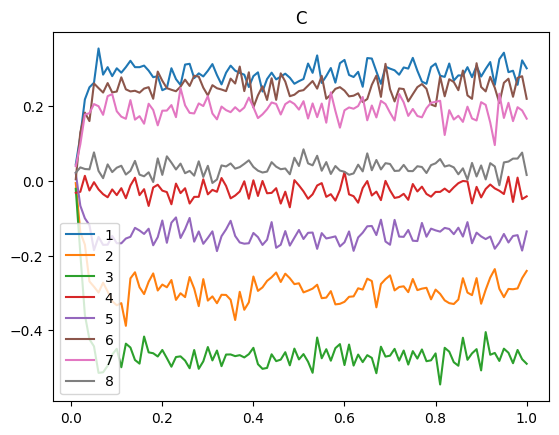

In [16]:
# Run it!
with nengo.Simulator(model) as sim:
    sim.run(1)

# Plot it!
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[C_probe])
plt.title("C")
plt.legend(['1','2','3','4','5','6','7','8'], loc="best")

Now we have to add the appropriate elements to complete matrix multiplication. We use the same `transform` argument (i.e. decoders/weights) to choose which of the outputs from C should be added together. 

In [17]:
with model:
    # Now do the appropriate summing
    D = nengo.networks.EnsembleArray(
        100, n_ensembles=Amat.shape[0] * Bmat.shape[1], radius=1
    ) # sanity check that this is the right size for any matrix multiplication!

# The mapping for this transformation is much easier, since we want to
# combine pairs from C within D.
transformC = np.zeros((D.dimensions, c_size))
for i in range(c_size):
    transformC[i // Bmat.shape[0]][i] = 1
print("C->D")
print(transformC)

with model:
    nengo.Connection(C.output, D.input, transform=transformC)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)

C->D
[[1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]]


We have 8 outputs from C. We add two at a time to compute the four outputs of our two 2x2 matrices being multiplied together.

Recall:
$$ \vec{A} \vec{B}  
=
\begin{bmatrix} 
	a_{11} & a_{12} \\
	a_{21} & a_{22}  
\end{bmatrix}
\begin{bmatrix} 
	b_{11} & b_{12} \\
	b_{21} & b_{22}  	
\end{bmatrix}
=
\begin{bmatrix} 
	a_{0} & a_{1} \\
	a_{2} & a_{3}  
\end{bmatrix}
\begin{bmatrix} 
	b_{0} & b_{1} \\
	b_{2} & b_{3}  	
\end{bmatrix}
\\ 
=
\begin{bmatrix} 
	a_{11}  b_{11} + a_{12}b_{21} & a_{11} b_{12}+a_{12}b_{22} \\
	a_{21}  b_{11} + a_{22}b_{21} & a_{21}  b_{12} + a_{22}b_{22} 	
\end{bmatrix} 
=
\begin{bmatrix} 
	a_{0}  b_{0} + a_{1}b_{2} & a_{0} b_{1}+a_{1}b_{3} \\
	a_{2}  b_{0} + a_{3}b_{2} & a_{2}  b_{1} + a_{0}b_{3} 	
\end{bmatrix} $$

Now, let's run it and see our final answer!

Build finished in 0:00:03.                                                      
Simulation finished in 0:00:04.                                                 


Text(0.5, 1.0, 'D')

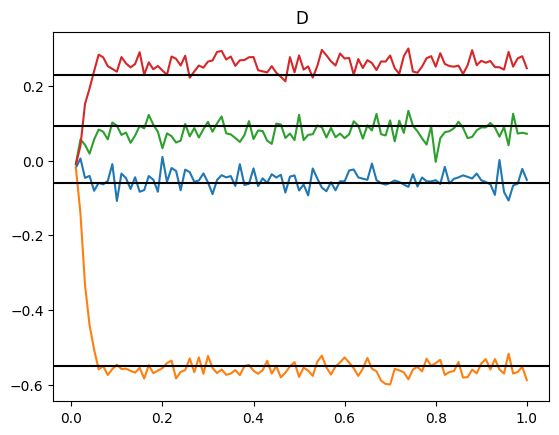

In [18]:
# Run it!
with nengo.Simulator(model) as sim:
    sim.run(1)

# Plot it!
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[D_probe])
for d in np.dot(Amat, Bmat).flatten():
    plt.axhline(d, color="k")
plt.title("D")

#### Discussion

We could have written matrix multiplication manually using our own multiplication function from last time. That may have made it more intuitive, and we could have possibly found a faster way to do it! 

That said, now you have experience using a pre-built Nengo network AND the transform argument, which will come in handy as we continue to map algorithms to neurons.

#### Recurrence